In [2]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker

# ps
import pysindy as ps

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

In [ ]:
import sys; sys.path.insert(1, '../')
from SIQLib.trainNN import *
from SIQLib.Sample import *

In [4]:
class System(object):
    def __init__(self, dim, xrange=[-2, 2], yrange=[-1.5, 1.5], zrange=[-1.5, 1.5]): 
        self.dim    = dim
        self.xrange = xrange
        self.yrange = yrange
        self.zrange = zrange
    def get_force(self,X,rho=1.): 
        if np.size(X.shape)==2:
            b       = np.zeros(dtype=np.float64,shape=X.shape)
            b[:,0]  = -2*(X[:,0]**3-X[:,0])-rho*np.sum(X[:,1:],axis=-1)
            b[:,1:] = -X[:,1:]+2*rho*np.reshape(X[:,0]**3-X[:,0],[-1,1])
        else:
            b     = np.zeros(dtype=np.float64,shape=(self.dim,))
            b[0]  = -2*(X[0]**3-X[0])-rho*np.sum(X[1:])
            b[1:] = -X[1:] + 2*rho*(X[0]**3-X[0])
        return b
dim = 3
SYS = System(dim=dim)

# data

In [7]:
ll = np.array([2,1.5,1.5])
def sample_initial(n,ll,center=[0]*dim):
    X = np.random.uniform(-1,1,(n,dim))*ll + center
    if n==1: X = X[0]
    return X

(175000, 3) (8265, 3)


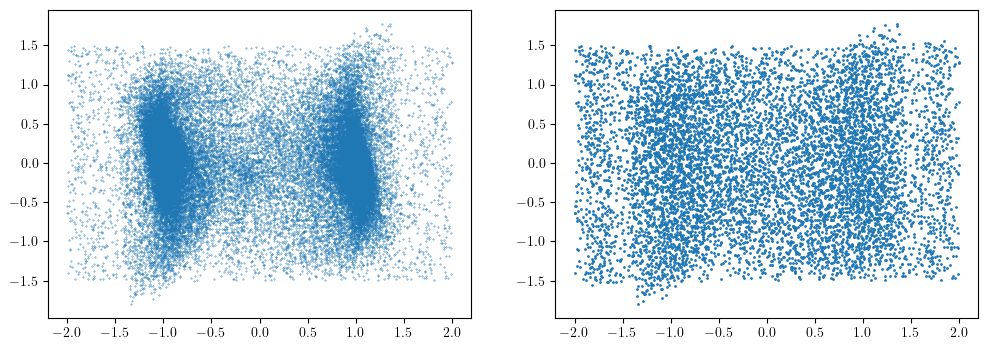

In [8]:
data_train,data_test,X0X1 = torch.load('data_ex1')
X,Xhat = data_train[0][:,:dim],data_train[1]
print(X.shape,Xhat.shape)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(X[:,0],X[:,1],s=.1)
ax[1].scatter(Xhat[:,0],Xhat[:,1],s=1)
plt.show()

# Set the model

In [9]:
model_V = FCNN(input_dim=dim,output_dim=1,  num_hidden=3,hidden_dim=50,act=tanh).cuda()
model_g = FCNN(input_dim=dim,output_dim=dim,num_hidden=3,hidden_dim=50,act=tanh).cuda()
model   = SDE_model(model_V=model_V,model_g=model_g,dim=dim).cuda();
model.load_state_dict(torch.load("saved_models/model_ex1"))

<All keys matched successfully>

# Predicting the trajectories

In [10]:
def rL2(x,y): 
    x = np.reshape(x,(len(x),-1))
    y = np.reshape(y,(len(y),-1))
    return np.sqrt( np.sum((x-y)**2,axis=-1).mean()/np.sum(x**2,axis=-1).mean() )
def get_fNN(X,model=model):
    X    = torch.tensor(X,requires_grad=True).cuda()
    _,dV = model.get_V_dV(X)
    g    = model.get_g(X)
    f    = -dV+g
    return f.cpu().data.numpy()
def get_U(X): return X[:,0]**4-2*X[:,0]**2+1+X[:,1]**2+X[:,2]**2
def get_V_NN(X): return model.get_V_np(X)
def get_U_NN(X): return 2*model.get_V_np(X)
def get_V_True(X): return get_U(X)/2

X_error = [] # 2
for xx in np.linspace(SYS.xrange[0],SYS.xrange[1],100):
    for yy in np.linspace(SYS.yrange[0],SYS.yrange[1],100):
        for zz in np.linspace(SYS.zrange[0],SYS.zrange[1],100):
            X_error.append([xx,yy,zz])
X_error = np.vstack(X_error)
def error_U(model): 
    U    = get_U(X_error)
    U_NN = 2*model.get_V_np(X_error)
    U_NN = U_NN-U_NN.min()
    return rL2(U,U_NN)

In [11]:
print(error_U(model))
torch.cuda.empty_cache()

0.004391319958816673


In [12]:
Int_Pars = {}
Int_Pars['dt'] = 1e-2; Int_Pars['T'] = int(5); Int_Pars['m'] = 10; Int_Pars['integrator']=RK2;

def Prediction_f(get_f,X0,ax=None,Int_Pars=Int_Pars,get_f1=SYS.get_force,figname=None):
    dt,T,m,integrator = Int_Pars['dt'],Int_Pars['T'],Int_Pars['m'],Int_Pars['integrator']
    exact_traj = perform_ode(X0,get_f1,T,dt,m,integrator=RK4,num_steps=5,mode='X0',use_tqdm=False)
    learned_traj  = perform_ode(X0,get_f,T,dt,m,integrator,mode='X0',use_tqdm=False)
    errors = []
    for k in range(len(exact_traj)):
        errors.append(rL2(exact_traj[k],learned_traj[k]))
    print(learned_traj.shape,'%d trajs:  %.2e +- %.2e '%(len(learned_traj),np.mean(errors),np.std(errors)))

    if ax==None: fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=100,constrained_layout=True)
    id1 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-0.5,1.2],axis=-1))
    id2 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-1.5,-.2],axis=-1))
    id3 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[-.5,.5],axis=-1))
    id4 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[0.5,-0.8],axis=-1))
    id5 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[1.1,-1],axis=-1))
    id6 = np.argmin(np.linalg.norm(learned_traj[:,0,:2]-[1.5,0.3],axis=-1))
    
    ax.plot(learned_traj[[id1,id2,id3,id4,id5,id6],0][:,0], learned_traj[[id1,id2,id3,id4,id5,id6],0][:,1],'ko',
            markersize=6,label='Initial state')
    for kk,k in enumerate([id1,id2,id3,id4,id5,id6]):
        
        if kk==0: label = 'Observed traj.'
        else: label = None
        ax.plot(exact_traj[k,:,0],exact_traj[k,:,1],'r-',lw=3,label=label)
        
        if kk==0: label = 'Predicted traj.'
        else: label = None 
        ax.plot(learned_traj[k,:,0],learned_traj[k,:,1],'b--',lw=1,label=label)
        
    ax.set_xlim(SYS.xrange)
    ax.set_ylim(SYS.yrange)
    ax.set_xlabel(r'$x$', fontsize=15)
    ax.set_ylabel(r'$y$', fontsize=15, rotation=1)
    ax.text(-1.2,0,r'$A$',fontsize=18,ha='center', va='center')
    ax.text(1.2,0,r'$B$',fontsize=18,ha='center', va='center')
    ax.plot(-1 , 0,'kD')
    ax.plot(1,   0,'kD')
    ax.set_xticks([-2,-1,0,1,2])
    ax.set_yticks([-1,0,1])
    ax.tick_params(axis="both", labelsize=10)
    ax.legend(fontsize=10)
    if figname is not None: plt.savefig(figname,dpi=300,bbox_inches='tight')
    if ax is None: plt.show()
def plot_U(get_V,fig,ax,ax_bar=None,xrange=SYS.xrange,yrange=SYS.yrange,nx=501,ny=501,
           threshold=1e8,plot_cbar=False):
    xx     = np.linspace(xrange[0],xrange[1],nx)
    yy     = np.linspace(yrange[0],yrange[1],ny)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])
        
    U      = 2*get_V(X_u)
    U      = np.minimum(U-U.min(),threshold).reshape(XX.shape)
    c      = ax.contourf(XX,YY,U,25,cmap='terrain')
    if plot_cbar:
        if ax_bar is None: cbar = fig.colorbar(c,ax=ax,format='%4.1f',aspect=30)
        else: cbar = fig.colorbar(c,ax=ax_bar,format='%4.1f',aspect=30,pad=-1.1)
        cbar.ax.tick_params(labelsize=10)

In [13]:
X0 = sample_initial(1000,ll);

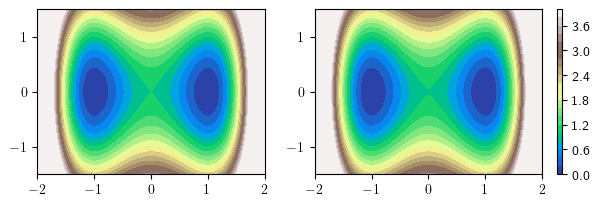

(1000, 50, 3) 1000 trajs:  1.38e-03 +- 6.80e-03 


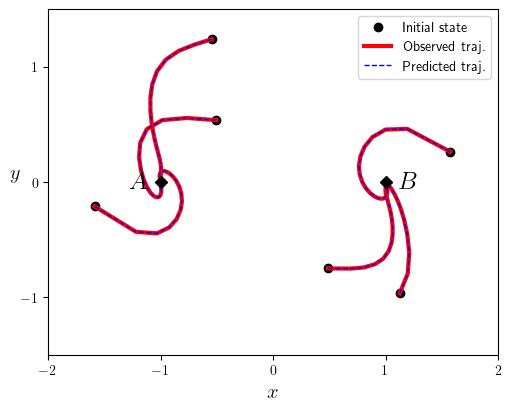

In [14]:
fig,ax = plt.subplots(1,2,figsize=(6,2),dpi=100,constrained_layout=True)
plot_U(get_V_True,fig,ax[0],threshold=4,plot_cbar=False)
plot_U(model.get_V_np,fig,ax[1],threshold=4,plot_cbar=True)
plt.show()

Prediction_f(get_fNN,X0)

# $V(x) = basis(x)\cdot [\xi_1,...,\xi_m]$, $\nabla V(x) = \nabla basis(x)\cdot [\xi_1,...,\xi_m]$
# For particular function library spaces, $\nabla V(x) = basis(x)\cdot T[\xi_1,...,\xi_m]$
# $g(x)= basis(x)\cdot[\psi_1,...,\psi_m]$
# $f(x)=-basis(x)\cdot T[\xi_1,...,\xi_m]+basis(x)\cdot[\psi_1,...,\psi_m]$
# Regression for $V$+Regression for $g$+Regression for $f$
# Build target matrix: $[f(x_i), V(x_i), g(x_i)]\in R^{(\# data)\times (2d+1)}$

In [15]:
def get_Y(X):
    fNN = get_fNN(X)
    VNN = model.get_V_np(X).reshape(-1,1)
    VNN = VNN-VNN.min()
    gNN = model.get_g_np(X)
    return np.hstack([fNN,VNN,gNN])
def get_mask(X,threshold=2):
    Vmin = get_V_NN(X_error).min()
    V = get_V_NN(X)-Vmin
    torch.cuda.empty_cache()
    return V<threshold

X = X[get_mask(X)]
Y   = get_Y(X)
print(X.shape,Y.shape,)

(174191, 3) (174191, 7)


# Set powers and lib

In [16]:
def write_form3(coef,power,var):
    for k in range(min(len(power),len(coef))):
        term = ''
        if power[k][0]==1: term = term + '%s'%(var[0])
        if power[k][1]==1: term = term + '%s'%(var[1])
        if power[k][2]==1: term = term + '%s'%(var[2])
        if power[k][0]>1: term = term + '%s^%d'%(var[0],power[k][0])
        if power[k][1]>1: term = term + '%s^%d'%(var[1],power[k][1])
        if power[k][2]>1: term = term + '%s^%d'%(var[2],power[k][2])
        if coef[k]>1e-10: print('+ '+str(coef[k])+' '+term,end=' ')
        if coef[k]<-1e-10: print('- '+str(abs(coef[k]))+' '+term,end=' ')
    print()

In [17]:
degree_V = 5
degree_g = 5
degree   = max(degree_V,degree_g)

power = {}
k = 0
get_k = {}
for n in range(degree+1):
    for nx in range(n,-1,-1):
        for ny in range(n-nx,-1,-1):
            nz = n-nx-ny
            power[k]        = [nx,ny,nz]
            get_k[nx,ny,nz] = k
            k               = k + 1

In [18]:
lib = ps.PolynomialLibrary(degree=degree,include_bias=True).fit(X)
print(f"Features ({lib.n_output_features_}):",lib.get_feature_names())
print()

Features (56): ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2', 'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3', 'x0^4', 'x0^3 x1', 'x0^3 x2', 'x0^2 x1^2', 'x0^2 x1 x2', 'x0^2 x2^2', 'x0 x1^3', 'x0 x1^2 x2', 'x0 x1 x2^2', 'x0 x2^3', 'x1^4', 'x1^3 x2', 'x1^2 x2^2', 'x1 x2^3', 'x2^4', 'x0^5', 'x0^4 x1', 'x0^4 x2', 'x0^3 x1^2', 'x0^3 x1 x2', 'x0^3 x2^2', 'x0^2 x1^3', 'x0^2 x1^2 x2', 'x0^2 x1 x2^2', 'x0^2 x2^3', 'x0 x1^4', 'x0 x1^3 x2', 'x0 x1^2 x2^2', 'x0 x1 x2^3', 'x0 x2^4', 'x1^5', 'x1^4 x2', 'x1^3 x2^2', 'x1^2 x2^3', 'x1 x2^4', 'x2^5']



# Symbolic for fVg

In [19]:
j = 0
n_features  = len(power)
constraints = np.zeros((len(power)*dim*2,n_features*(dim+1+dim)))
for k in range(len(power)):
    nx,ny,nz = power[k]
    
    # f1
    constraints[j,k] = 1
    if nx+ny+nz+1<=degree_V: constraints[j,n_features*dim+get_k[nx+1,ny,nz]] = (nx+1)
    constraints[j,n_features*(dim+1)+k] = -1
    j = j + 1
    
    # f2
    constraints[j,n_features+k] = 1
    if nx+ny+nz+1<=degree_V: constraints[j,n_features*dim+get_k[nx,ny+1,nz]] = (ny+1)
    constraints[j,n_features*(dim+2)+k] = -1
    j = j + 1
    
    # f3
    constraints[j,n_features*2+k] = 1
    if nx+ny+nz+1<=degree_V: constraints[j,n_features*dim+get_k[nx,ny,nz+1]] = (nz+1)
    constraints[j,n_features*(dim+3)+k] = -1
    j = j + 1
    
# for k in range(len(power)):
#     nx,ny,nz = power[k]
#     if nx+ny+nz>degree_g: constraints[j,n_features*(dim+1)+k] = 1; j=j+1
#     if nx+ny+nz>degree_g: constraints[j,n_features*(dim+2)+k] = 1; j=j+1
#     if nx+ny+nz>degree_g: constraints[j,n_features*(dim+3)+k] = 1; j=j+1
        
constraints = constraints[:j]
constraints.shape,np.zeros(len(constraints)).shape

((168, 392), (168,))

In [20]:
initial_guess_Y   = None
optimizer_sr3_con = ps.optimizers.constrained_sr3.ConstrainedSR3(threshold=.2, nu=1e-2, 
                        max_iter=int(1e5),
                        initial_guess=initial_guess_Y,
                        constraint_lhs=constraints,constraint_rhs=np.zeros(len(constraints)))
sindy_total = ps.SINDy(optimizer=optimizer_sr3_con,feature_library=lib,feature_names=['x','y','z'])

In [21]:
def get_f_from_total(X): return sindy_total.predict(X)[:,:dim]
def get_V_from_total(X): return sindy_total.predict(X)[:,dim]
def get_U_from_total(X): return 2*sindy_total.predict(X)[:,dim]
def get_dV_from_total(X):
    coef  = sindy_total.coefficients()[dim]
    x,y,z = X[:,0],X[:,1],X[:,2]
    Vx,Vy,Vz = 0,0,0
    for k in range(len(power)):
        if power[k][0]>=1:
            Vx = Vx + power[k][0]*coef[k]*x**(power[k][0]-1)*y**power[k][1]*z**power[k][2]
        if power[k][1]>=1:
            Vy = Vy + power[k][1]*coef[k]*x**power[k][0]*y**(power[k][1]-1)*z**power[k][2]
        if power[k][2]>=1:
            Vz = Vz + power[k][2]*coef[k]*x**power[k][0]*y**power[k][1]*z**(power[k][2]-1)
    return np.hstack([np.reshape(Vx,(-1,1)),np.reshape(Vy,(-1,1)),np.reshape(Vz,(-1,1))])
def get_ndV_from_total(X): return -get_dV_from_total(X)
def get_g_from_total(X): 
    return np.array(sindy_total.predict(X)[:,dim+1:])
def get_f_from_total2(X): 
    return -get_dV_from_total(X)+get_g_from_total(X)

No. of ites: 0
2.092392710574897e-05

f1(x,y,z) = 2.00089 x + -1.00001 y + -1.00004 z + -2.00069 x^3
f2(x,y,z) = -2.00349 x + -0.99914 y + 2.00328 x^3
f3(x,y,z) = -2.00280 x + -0.99916 z + 2.00264 x^3
V(x,y,z) = 0.50048 1 + -1.00046 x^2 + 0.49951 y^2 + 0.49952 z^2 + 0.50013 x^4
g1(x,y,z) = -1.00003 y + -1.00012 z
g2(x,y,z) = -2.00351 x + 2.00331 x^3
g3(x,y,z) = -2.00287 x + 2.00265 x^3

relative error of the regression: 0.0036655312143593468
extended error for f: 0.00339
extended error for V: 0.00216
extended error for g: 0.00429


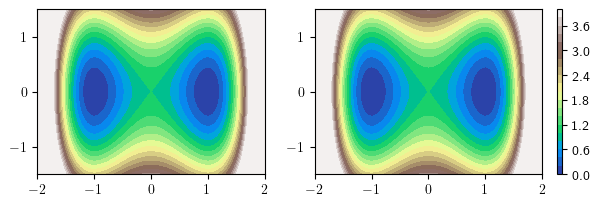

+ 1.001  - 2.001 x^2 + 0.999 y^2 + 0.999 z^2 + 1.0 x^4 
- 1.0 y - 1.0 z 
- 2.004 x + 2.003 x^3 
- 2.003 x + 2.003 x^3 
8.71962022781372


In [22]:
import time
tt = time.time()

sindy_total.optimizer.threshold = .1
sindy_total.optimizer.nu        = 1e-5
sindy_total.fit(X,x_dot=Y);

print('No. of ites:',sindy_total.optimizer.iters)
def l2_norm(X): return np.sqrt(np.mean(X**2))
print(l2_norm(constraints@sindy_total.coefficients().reshape(-1,1)))
print()
sindy_total.print(lhs=["f1(x,y,z)","f2(x,y,z)","f3(x,y,z)","V(x,y,z)","g1(x,y,z)","g2(x,y,z)","g3(x,y,z)"],
                  precision=5)
print()
print('relative error of the regression:',rL2(Y,sindy_total.predict(X)))

print('extended error for f: %.5f' % rL2(Y[:,:dim],get_f_from_total(X)))
print('extended error for V: %.5f' % rL2(Y[:,dim], get_V_from_total(X)))
print('extended error for g: %.5f' % rL2(Y[:,dim+1:],get_g_from_total(X)))

fig,ax = plt.subplots(1,2,figsize=(6,2),dpi=100,constrained_layout=True)
plot_U(get_V_True,fig,ax[0],threshold=4,plot_cbar=False)
plot_U(get_V_from_total,fig,ax[1],threshold=4,plot_cbar=True)
plt.show()

coef = sindy_total.coefficients()[3]*2
coef = np.round(coef*1000)/1000
write_form3(coef,power,['x','y','z'])

for k in range(3):
    coef = sindy_total.coefficients()[4+k]
    coef = np.round(coef*1000)/1000
    write_form3(coef,power,['x','y','z'])
    
print( time.time()-tt )

(1000, 50, 3) 1000 trajs:  3.04e-04 +- 6.55e-04 


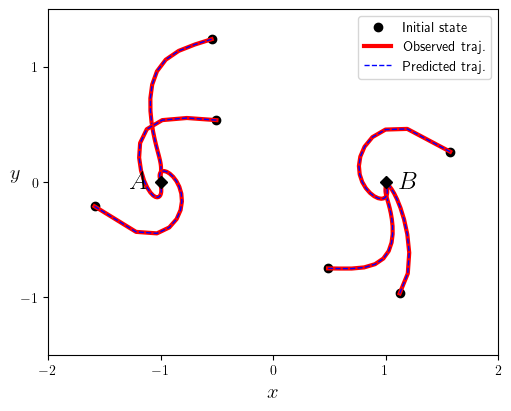

In [23]:
Prediction_f(get_f_from_total,X0)

# Show Results

In [24]:
def plot_vectorfield(get_g,fig,ax,xrange,yrange,nx=101,ny=101,get_mask=None):
    xx     = np.linspace(xrange[0],xrange[1],nx)
    yy     = np.linspace(yrange[0],yrange[1],ny)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])
    
    UU     = np.array(get_g(X_u)[:,0])
    VV     = np.array(get_g(X_u)[:,1])
 
    speed = np.sqrt(UU**2 + VV**2).reshape(XX.shape)
    lw = 5*speed / speed.max()
    
    if get_mask is not None: 
        mask = get_mask(X_u)
        UU[~mask]=np.nan; VV[~mask]=np.nan
    UU = UU.reshape(XX.shape)
    VV = VV.reshape(XX.shape)
    
    
    
    ax.streamplot(XX,YY,UU,VV, density=1.5, color='k', linewidth=lw)

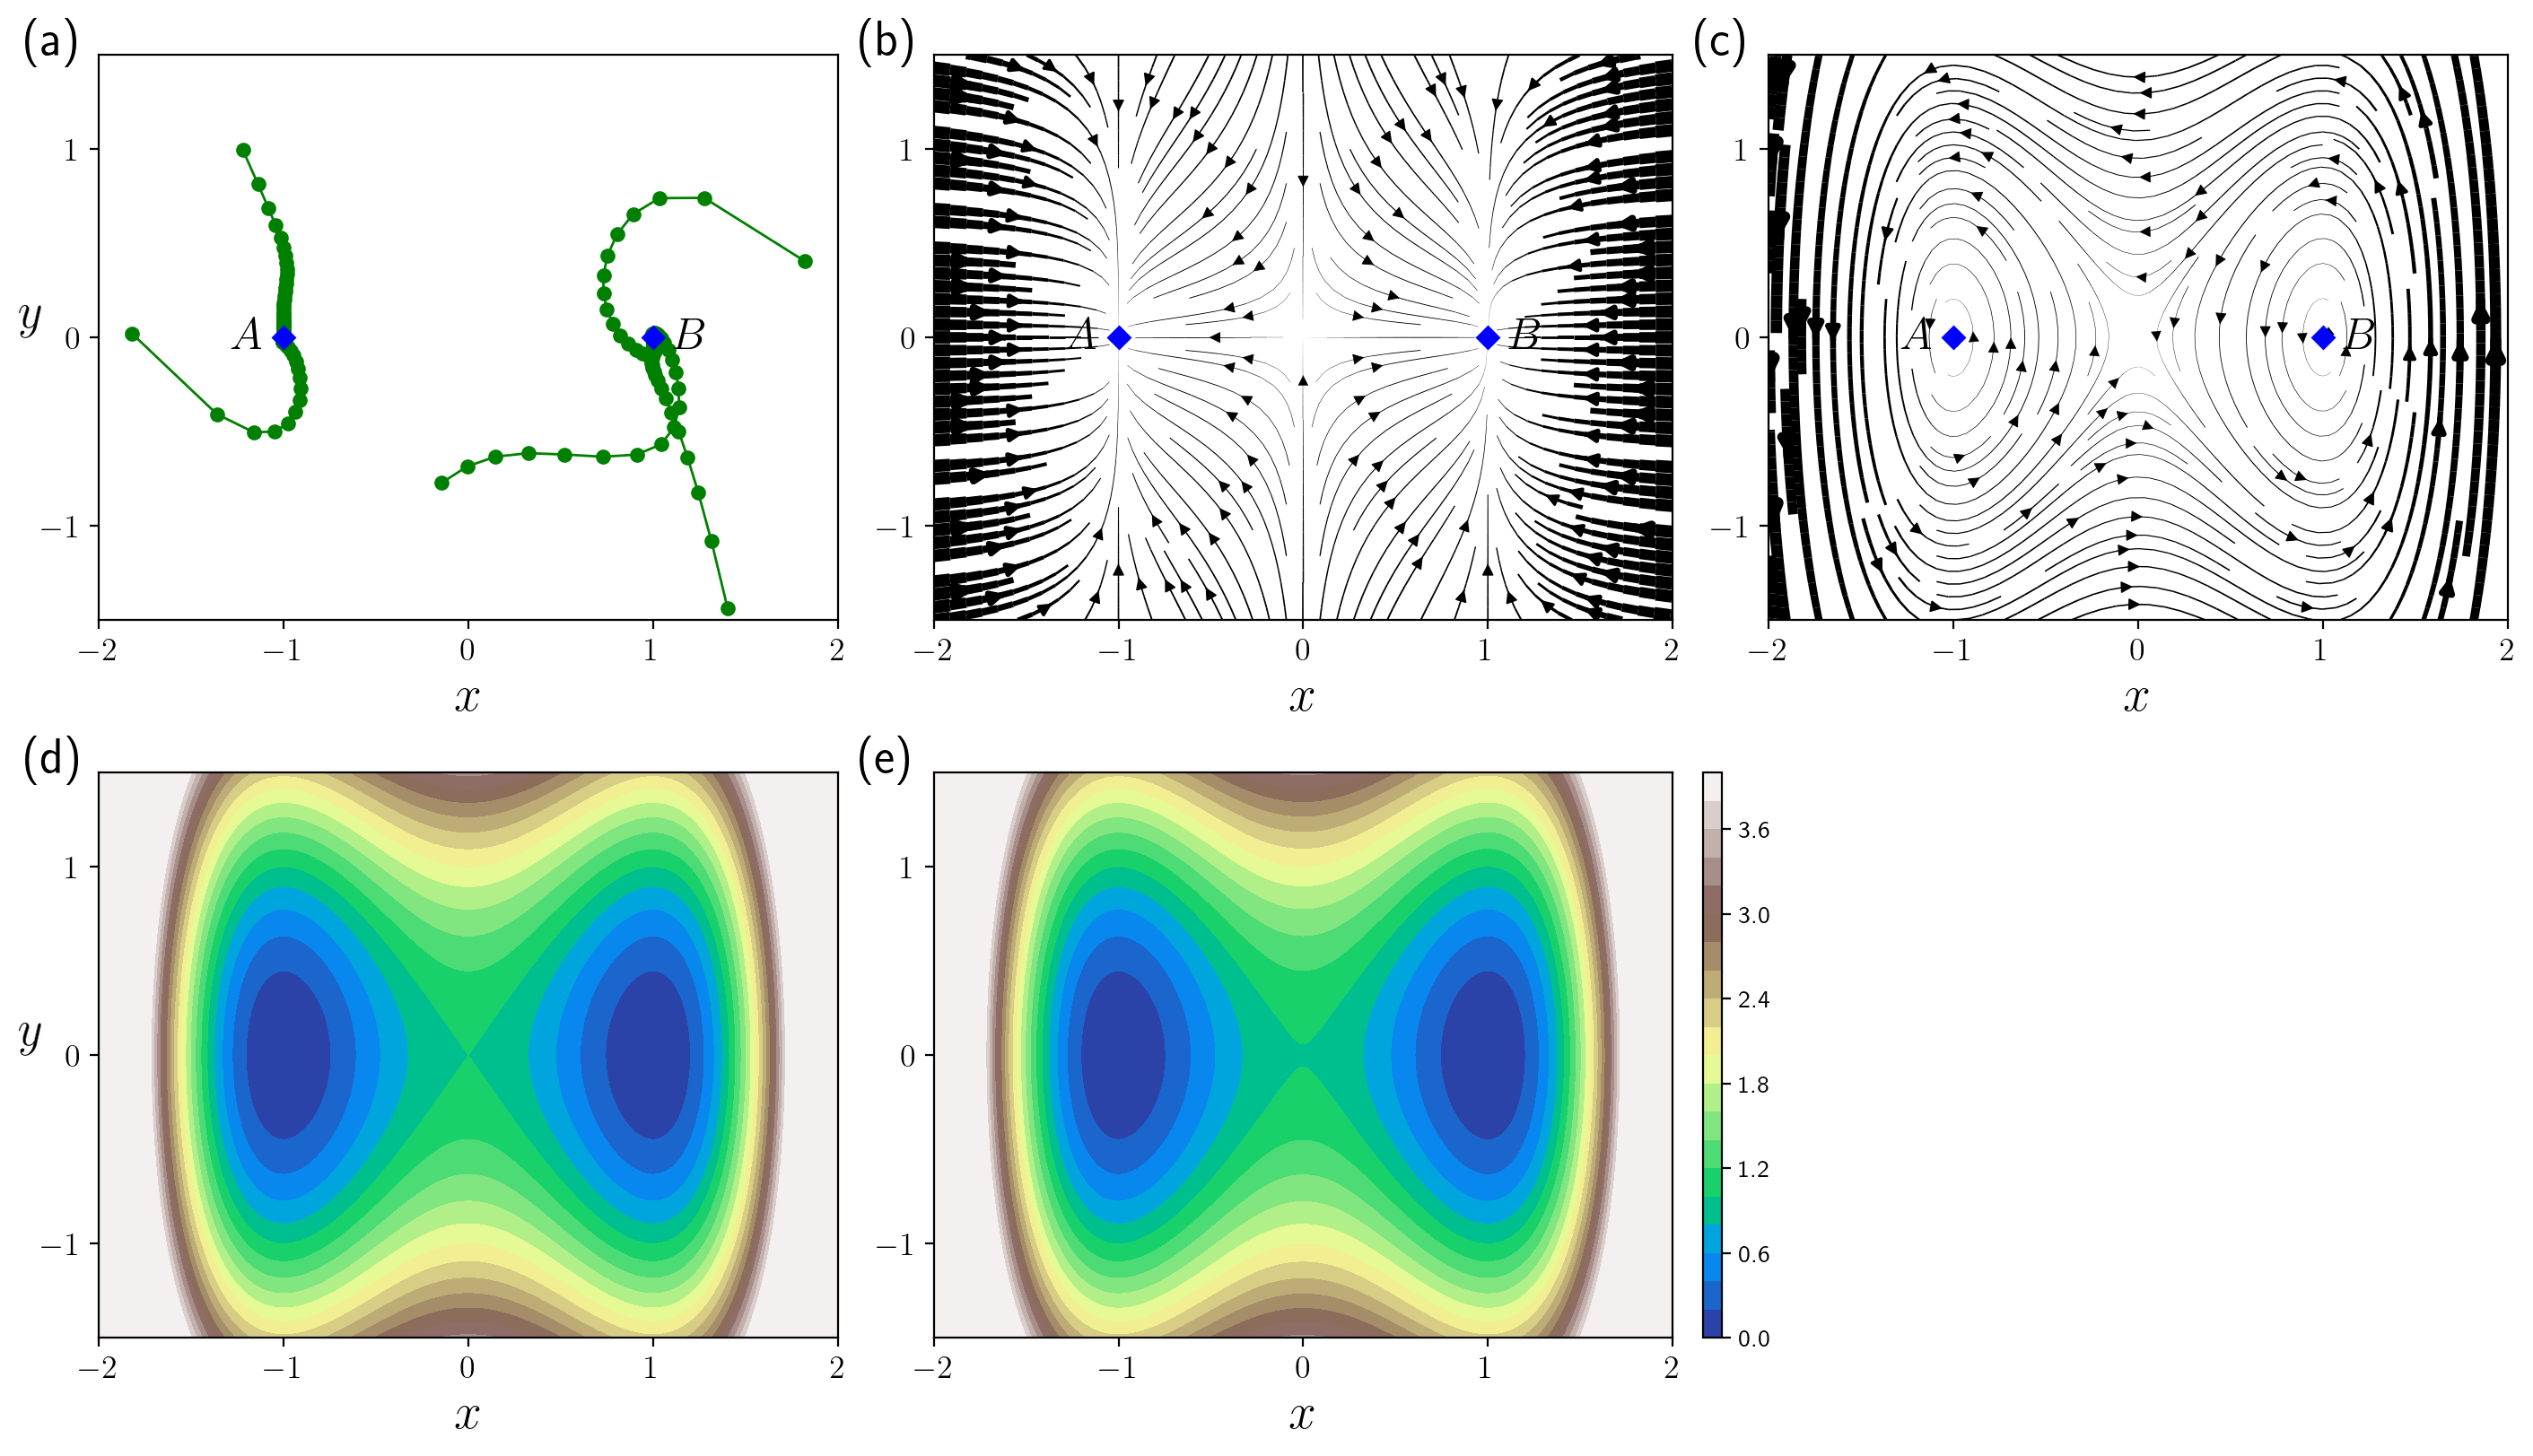

In [25]:
fig,ax = plt.subplots(2,3,figsize=(14,8),constrained_layout=True,dpi=200)

idx1 = np.argmin(np.linalg.norm(X0X1[:,0,0,:2]-[-1.8,0],axis=-1))
idx2 = np.argmin(np.linalg.norm(X0X1[:,0,0,:2]-[1.8,.4],axis=-1))
idx3 = np.argmin(np.linalg.norm(X0X1[:,0,0,:2]-[-1.2,1],axis=-1))
idx4 = np.argmin(np.linalg.norm(X0X1[:,0,0,:2]-[1.4,-1.4],axis=-1))
idx5 = np.argmin(np.linalg.norm(X0X1[:,0,0,:2]-[-.1,-.8],axis=-1))
ax[0,0].plot(X0X1[idx1,:,0,0],X0X1[idx1,:,0,1],'g-o',lw=1,mfc='green',markersize=5)
ax[0,0].plot(X0X1[idx2,:,0,0],X0X1[idx2,:,0,1],'g-o',lw=1,mfc='green',markersize=5)
ax[0,0].plot(X0X1[idx3,:,0,0],X0X1[idx3,:,0,1],'g-o',lw=1,mfc='green',markersize=5)
ax[0,0].plot(X0X1[idx4,:,0,0],X0X1[idx4,:,0,1],'g-o',lw=1,mfc='green',markersize=5)
ax[0,0].plot(X0X1[idx5,:,0,0],X0X1[idx5,:,0,1],'g-o',lw=1,mfc='green',markersize=5)

plot_U(get_V_True,fig,ax[1,0],ax[1,2],SYS.xrange,SYS.yrange,threshold=4,plot_cbar=False)
plot_U(model.get_V_np,fig,ax[1,1],ax[1,2],SYS.xrange,SYS.yrange,threshold=4,plot_cbar=True)
plot_vectorfield(get_ndV_from_total,fig,ax[0,1],SYS.xrange,SYS.yrange,get_mask=None)
plot_vectorfield(get_g_from_total,fig,ax[0,2],SYS.xrange,SYS.yrange,get_mask=None)

for k,ax_ in enumerate(ax.reshape(-1)[[0,1,2,3,4]]):
    
    ax_.set_xlim(SYS.xrange)
    ax_.set_ylim(SYS.yrange)
    ax_.set_xlabel(r'$x$', fontsize=20)
    if k==0 or k==3: ax_.set_ylabel(r'$y$', fontsize=20, rotation=1)
    if k<=2:
        ax_.text(-1.2,0,r'$A$',fontsize=18,ha='center', va='center')
        ax_.text(1.2,0,r'$B$',fontsize=18,ha='center', va='center')
        ax_.plot(-1 , 0,'bD',label='Attractor 1')
        ax_.plot(1,   0,'bD',label='Attractor 2')
    ax_.set_xticks([-2,-1,0,1,2])
    ax_.set_yticks([-1,0,1])
    ax_.tick_params(axis="both", labelsize=13)
    ax_.text(-0.1, 1, '(%s)'%(chr(ord('a') + k)), transform=ax_.transAxes, size=20, weight='bold')

ax[-1,-1].axis('off')
plt.savefig('fig1a_',dpi=400,bbox_inches = 'tight')
plt.show()